# User Evaluation Detect and Predict Asus4onE

* ユーザー評価用のスクリプト
* マルチアウトプットを実装

In [1]:
import sounddevice as sd
import numpy as np
import socket
import librosa
import sys
import math
import matplotlib.pyplot as plt
import time as ti
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model

In [2]:
# model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1500/As4Drop_.12_0.0407_0.9990_0.9993_0.9973_0.9988_0.9985_0.9958.hdf5")
# model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1000/As4_.10_0.0074_0.9994_1.0000_0.9946_0.9946_0.9973_0.9946.hdf5")
# model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1580/As4_.10_0.0221_0.9975_0.9992_0.9976_0.9981_0.9987_0.9979.hdf5")
# model2 = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_1000/As4_.10_0.0074_0.9994_1.0000_0.9946_0.9946_0.9973_0.9946.hdf5")
model = load_model("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/models/models_Asus4onE_color_1000/As4_color_.08_0.0161_0.9973_0.9965_0.9985_0.9960_0.9958_0.9942.hdf5")

In [3]:
hz_array = np.array([32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49.0, 51.91, 55.0, 58.27, 61.74,
                    65.41, 69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98.0, 103.83, 110.0, 116.54, 123.47,
                    130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.0, 196.0, 207.65, 220.0, 233.08, 246.94,
                    261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.0, 415.3, 440.0, 466.16, 493.88,
                    523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.0, 932.33, 987.77,
                    1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.0, 1864.66,
                    1975.53, 2093.0])

hz_notename = {32.7: 'C1', 34.65: '#C1', 36.71: 'D1', 38.89: '#D1', 41.2: 'E1', 43.65: 'F1',
                46.25: '#F1', 49.0: 'G1', 51.91: '#G1', 55.0: 'A1', 58.27: '#A1', 61.74: 'B1',
                65.41: 'C2', 69.3: '#C2', 73.42: 'D2', 77.78: '#D2', 82.41: 'E2', 87.31: 'F2',
                92.5: '#F2', 98.0: 'G2', 103.83: '#G2', 110.0: 'A2', 116.54: '#A2', 123.47: 'B2',
                130.81: 'C3', 138.59: '#C3', 146.83: 'D3', 155.56: '#D3', 164.81: 'E3', 174.61: 'F3',
                185.0: '#F3', 196.0: 'G3', 207.65: '#G3', 220.0: 'A3', 233.08: '#A3', 246.94: 'B3',
                261.63: 'C4', 277.18: '#C4', 293.66: 'D4', 311.13: '#D4', 329.63: 'E4', 349.23: 'F4',
                369.99: '#F4', 392.0: 'G4', 415.3: '#G4', 440.0: 'A4', 466.16: '#A4', 493.88: 'B4',
                523.25: 'C5', 554.37: '#C5', 587.33: 'D5', 622.25: '#D5', 659.25: 'E5', 698.46: 'F5',
                739.99: '#F5', 783.99: 'G5', 830.61: '#G5', 880.0: 'A5', 932.33: '#A5', 987.77: 'B5',
                1046.5: 'C6', 1108.73: '#C6', 1174.66: 'D6', 1244.51: '#D6', 1318.51: 'E6', 1396.91: 'F6',
                1479.98: '#F6', 1567.98: 'G6', 1661.22: '#G6', 1760.0: 'A6', 1864.66: '#A6', 1975.53: 'B6', 2093.0: 'C7'}

Asus4onE_chord_list = ["E2", "A2", "E3", "A3", "B3", "E4"]

In [4]:
sr = 22050
shift_size = 576
data_length = 1

hop_length = 1024
frame_length = 2048
pre_max = 30 / 1000 * sr // hop_length
post_max = 0 / 1000 * sr // hop_length + 1
pre_avg = 100 / 1000 * sr // hop_length
post_avg = 100 / 1000 * sr // hop_length + 1
wait = 300 / 1000 * sr // hop_length
delta = 0.4

# expected_note_times = [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0]
# expected_note_times = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]
expected_note_times = [1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5]
expected_note_points = [int((expected_note_time * sr) + frame_length) for expected_note_time in expected_note_times]

In [5]:
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])):
        return array[idx - 1]
    else:
        return array[idx]
    
def callback_pitch(indata, frames, time, status):
    global data, chord_list, before_pitch_name
    
    data = np.roll(data, -shift_size, axis=0)
    data[-shift_size:] = indata.reshape((shift_size,))

    rms = np.sqrt(np.mean(indata**2))
    db = 20 * math.log10(rms)

    if db >= -50:
        
        _f0 = librosa.yin(y=data, sr=sr, fmin=60, fmax=440)
        _f0 = [find_nearest(hz_array, i) for i in list(_f0)]
        latest_notes_list = []

        for i in _f0:
            latest_notes_list.append(float(i))

        max_note = max(latest_notes_list, key=latest_notes_list.count)
        pitch_name = hz_notename[max_note]

        if before_pitch_name != pitch_name:
            before_pitch_name = pitch_name
            if len(chord_list) == 0:
                pass
            else:
                if pitch_name == chord_list[0]:
                    del chord_list[0]
                    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
                    sock.sendto(str(1111).encode('utf-8'), (HOST, PORT))
                    sock.close()
                    print(pitch_name)
                    print(datetime.datetime.now().isoformat())
                else:
                    pass

In [6]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def min_max_normalize(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

def onset_detection(y, sr, rate, frame_length, hop_length, params):
    rms = librosa.feature.rms(y=y*rate, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=params["pre_max"], post_max=params["post_max"], pre_avg=params["pre_avg"], post_avg=params["post_avg"], delta=params["delta"], wait=params["wait"])
    times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
    return onset_envelope, onset_frames, times

def create_array(full_data, detected_num):
    window_size = 22050
    front_padding = 22050
    back_padding = 44100
    result = []

    for i in detected_num:
        start = max(0, i - front_padding)
        end = min(len(full_data), i + back_padding)

        if end - start < front_padding + back_padding:
            # Padding if the window size is not fully covered
            padding_start = max(0, front_padding - i)
            padding_end = max(0, back_padding - (len(full_data) - i))
            cliped_data = np.pad(full_data[start:end], (padding_start, padding_end), mode='constant')
        else:
            cliped_data = full_data[start:end]

        result.append(cliped_data)

    return np.array(result)

def predict_performances(y, model):
    x = y.reshape(len(y))
    melsp = calculate_melsp(x)
    
    pred = model.predict(melsp.reshape(1, 128, 517, 1))
    result = ""
    for i in range(1, 6):
        result += str(np.argmax(pred[6-i])) + ","
        
    result += str(np.argmax(pred[0]))
    
    return result

def callback_rythm(indata, frames, time, status):
    global data, onset_frames, non_negative_data, start_time, full_data
    data = np.roll(data, -shift_size, axis=0)
    data[-shift_size:] = indata.reshape((shift_size,))
    full_data = np.roll(full_data, -shift_size, axis=0)
    full_data[-shift_size:] = indata.reshape((shift_size,))

    src = data.reshape(data.size) * 100
    rms = librosa.feature.rms(y=src, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)
  
    if len(onset_frames) != 0:
        _times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
        for onset_frame in onset_frames:
            elapsed_time = (ti.time() - start_time) - (data_length - _times[onset_frame])
            
            if any(abs(elapsed_time - t) < 1.0 for t in detected_onset_times):
                continue
                
            detected_onset_times.append(elapsed_time)
            
            print(f"detect onset: {elapsed_time}")
            sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            sock.sendto(str(elapsed_time).encode('utf-8'), (HOST, PORT))

def receive_unity_instruction(server_ip, server_port):    
    # ソケットを作成してバインド
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((server_ip, server_port))
    
    # クライアントからの接続を待機
    server_socket.listen(1)
    print(f"Waiting for connection on {server_ip}:{server_port}")
    
    # 接続を受け入れる
    client_socket, client_address = server_socket.accept()
    print(f"Connected by {client_address}")
    
    # データの受信と表示
    data = client_socket.recv(1024)
    print(f"Received data: {data.decode('utf-8')}")
    
    # ソケットを閉じる
    client_socket.close()
    server_socket.close()

    return data.decode('utf-8')
        

def send_data_to_server(server_ip, server_port, message):
    # ソケットを作成
    with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as client_socket:
        # メッセージをサーバーに送信
        client_socket.sendto(message.encode('utf-8'), (server_ip, server_port))

def recive_data_from_server(port):
    # UDPソケットの作成
    # with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
    #     # アドレスとポートをバインド
    #     sock.bind(("", port))
    #     print(f"UDP server listening on :{port}")

    #     data, addr = sock.recvfrom(1024)  # バッファサイズは1024バイト
        
    #     return data.decode()
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(("", port))
    print(f"UDP server listening on :{port}")
    data, addr = sock.recvfrom(1024)
    sock.close()

    return data.decode()

input device:  Mic | Line 1/2 (Audient EVO4) 

output device:  Main Output 1/2 (Audient EVO4) 

Waiting for connection on 192.168.0.25:50003
Connected by ('192.168.0.20', 64911)
Received data: 0001
Lesson Scene Start ---
detect onset: 1.9833707217780912
detect onset: 3.9761807326881256
detect onset: 6.016420066794571
detect onset: 8.047568023642715
detect onset: 10.068105876883681
detect onset: 12.019379318198379
detect onset: 14.009097278556045
detect onset: 16.021169364890273
18.00309443473816


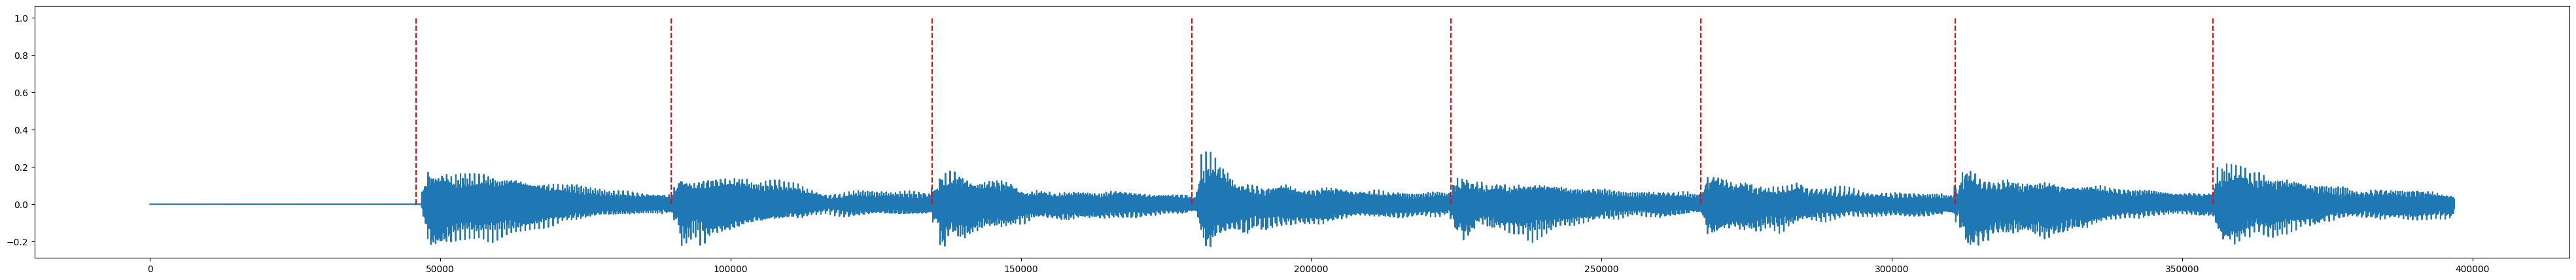

1/1 [==============================] - 8s 8s/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
0
------------
Waiting for connection on 192.

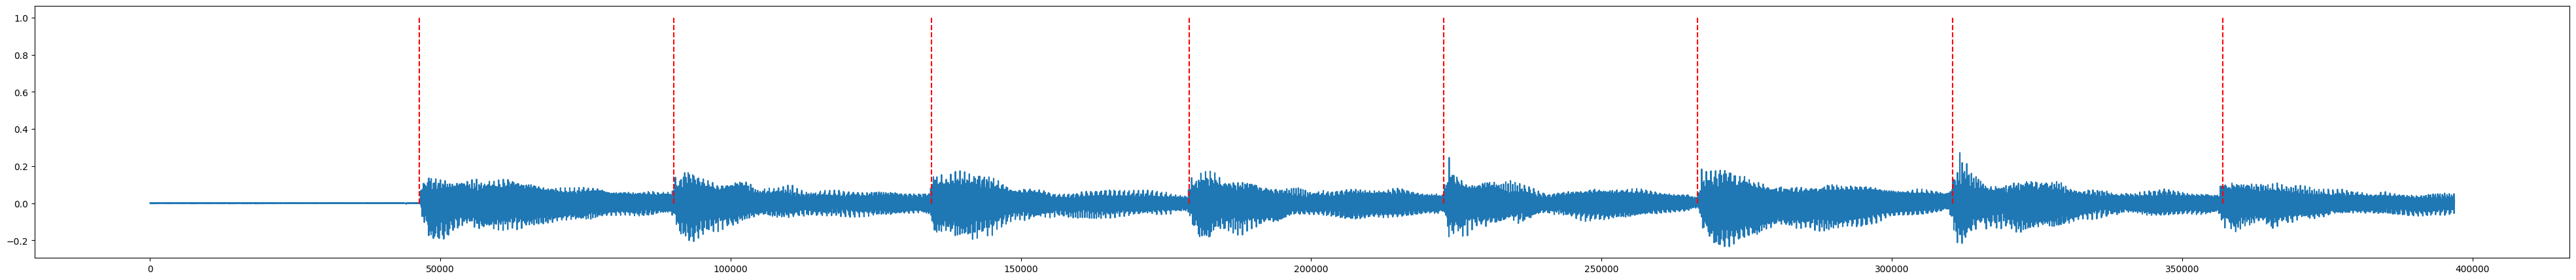

1/1 [==============================] - 0s 22ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 22ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
1
------------
Waiting for connection on 19

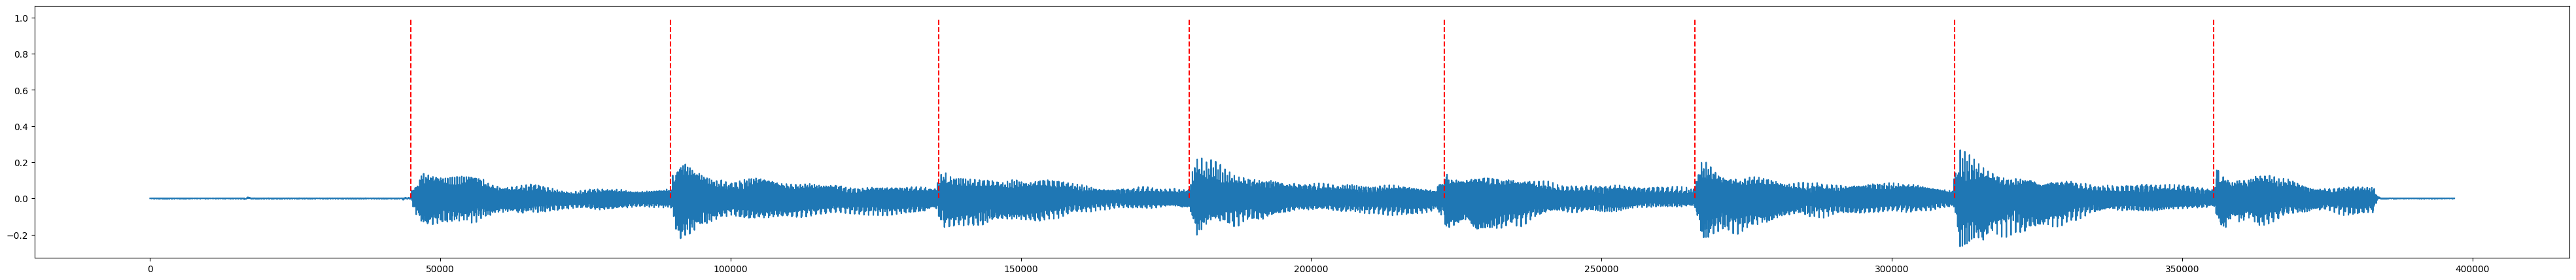

1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
2
------------
Waiting for connection on 19

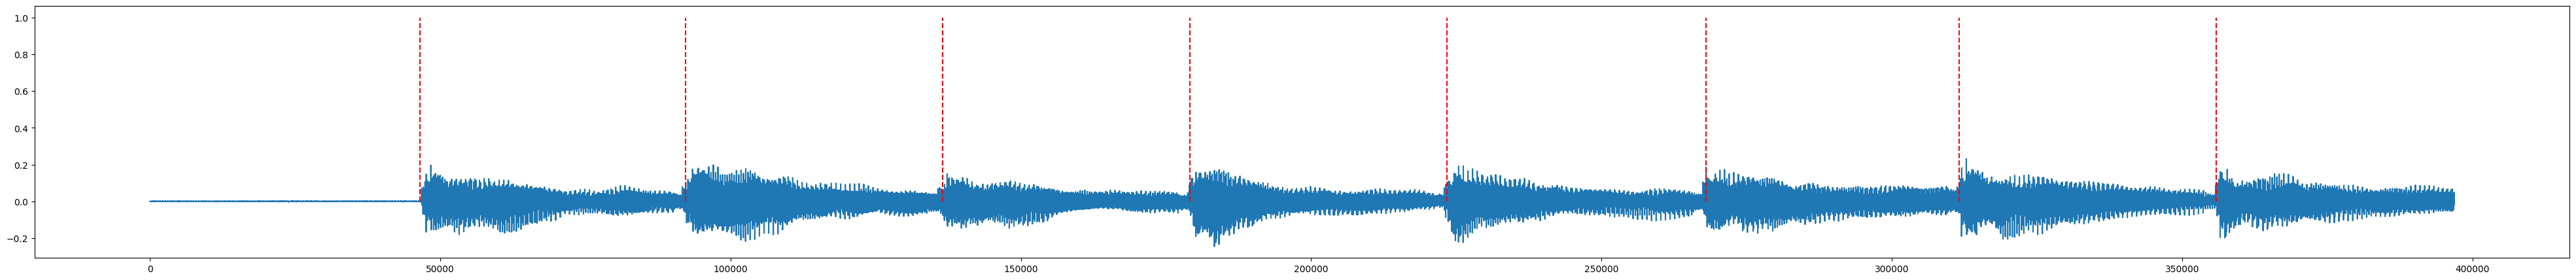

1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
3
------------
Waiting for connection on 19

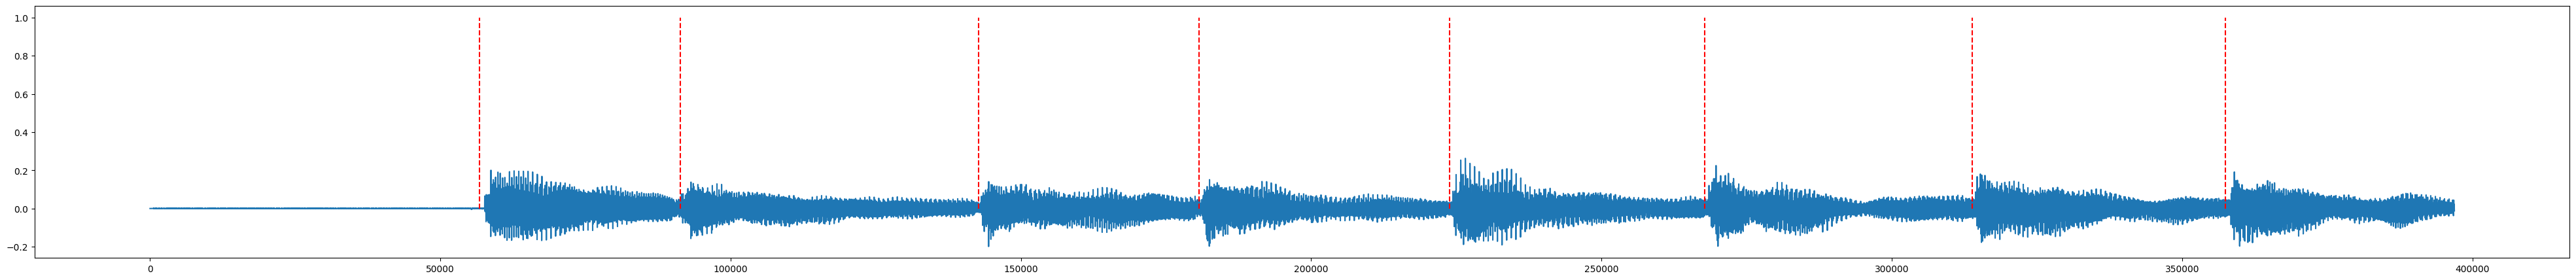

1/1 [==============================] - 0s 20ms/step
0,0,0,0,1,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 22ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 23ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 22ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
4
------------
Waiting for connection on 19

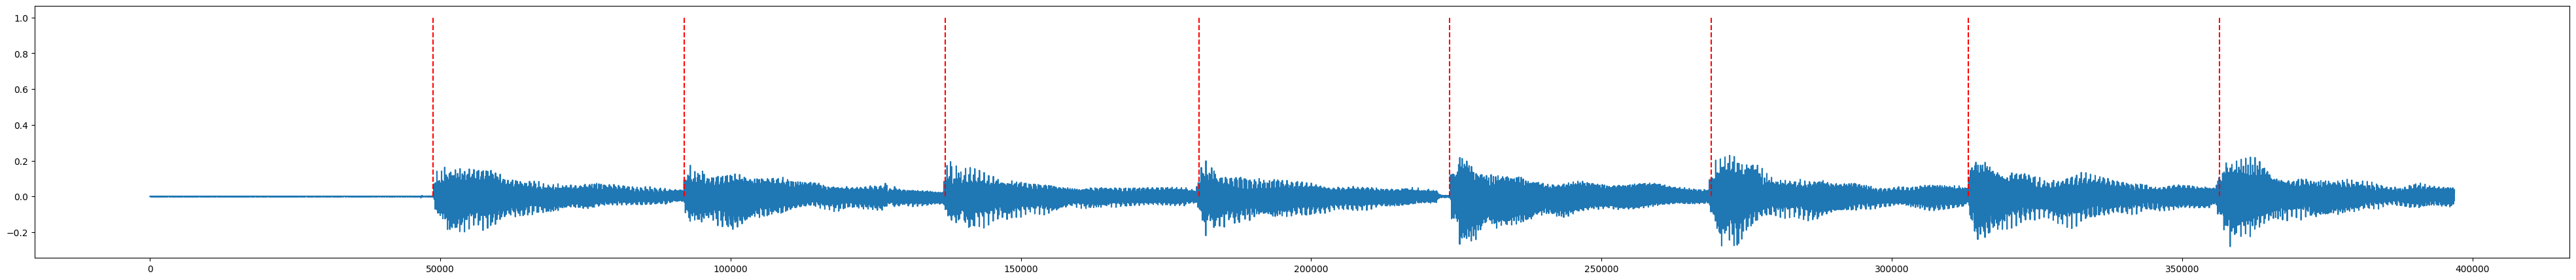

1/1 [==============================] - 0s 22ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,1,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,1,1,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 18ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
5
------------
Waiting for connection on 19

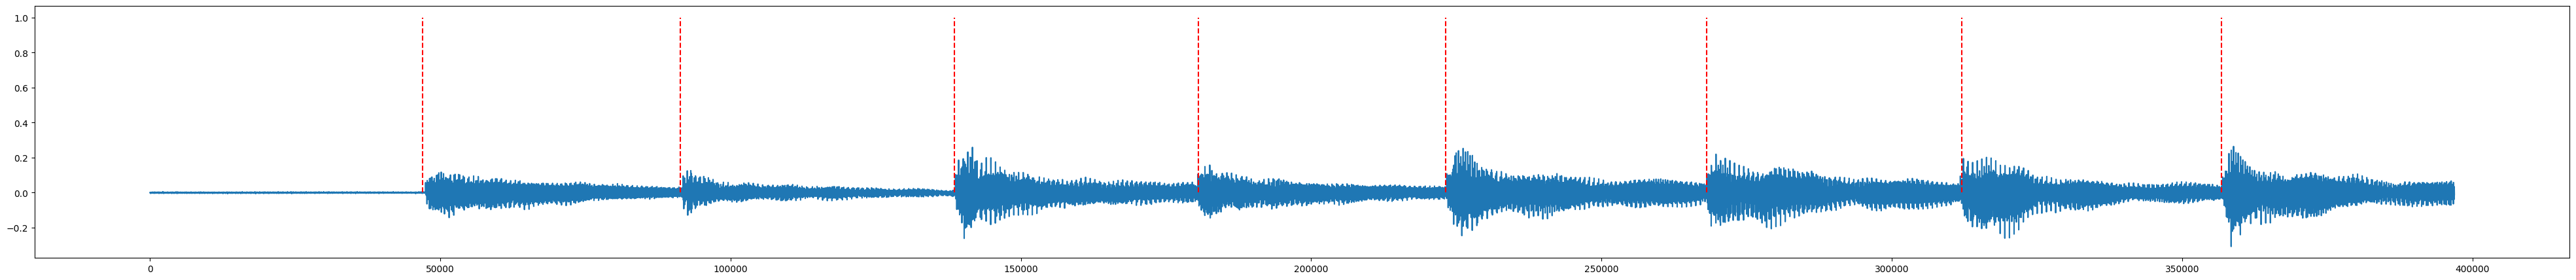

1/1 [==============================] - 0s 19ms/step
0,0,0,1,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 19ms/step
0,0,1,1,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,1,1,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,1,1,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 20ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
1/1 [==============================] - 0s 21ms/step
0,0,0,0,0,0
UDP server listening on :50005
Received message: 0101
------------
6
------------
Waiting for connection on 19

In [ ]:
# input_device = int(input("input device number: "))
# output_device = int(input("output device number: "))
input_device = 1
output_device = 10

sd.default.device = [input_device, output_device]

print("input device: ", sd.query_devices(kind="input")["name"], "\n")
print("output device: ", sd.query_devices(kind="output")["name"], "\n")

debug = False
# debug = True
if debug:
    HOST = "192.168.0.25"
else:
    HOST = "192.168.0.20"
LOCAL_HOST = "192.168.0.25"
PORT = 50003
PORT2 = 50005

for i in range(100):
    scene_code = receive_unity_instruction(LOCAL_HOST, PORT)
    
    if scene_code == '0010':
        print("Pitch Scene Start ---")
    
        duration = 3
        
        data = np.zeros(int(44100), dtype=np.float32)
        shift_size = 1136
        sr = 44100
    
        chord_list = Asus4onE_chord_list.copy()
        before_pitch_name = "null"
    
        while len(chord_list) != 0:
            with sd.InputStream(
                    channels=1,
                    dtype='float32',
                    callback=callback_pitch
                ):
                sd.sleep(int(duration * 1000))
                
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        end_code = "0000"
        sock.sendto(end_code.encode('utf-8'), (HOST, PORT))
        print("send 0000")
        sock.close()
        
    elif scene_code == '0001':
        print("Lesson Scene Start ---")
        duration = 18
        
        data = np.zeros(int(sr)*data_length, dtype=np.float32)
        full_data = np.zeros(int(sr)*duration, dtype=np.float32)
        onset_frames = []
        detected_onset_times = []
        
        with sd.InputStream(
                    samplerate=sr,
                    channels=1,
                    dtype='float32',
                    callback=callback_rythm
                ):
                start_time = ti.time()
                sd.sleep(int(duration * 1000))
                print(ti.time() - start_time)
                sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
                sock.sendto(str(0000).encode('utf-8'), (HOST, PORT))
        
        detected_num = [int((detected_onset_time * sr) + frame_length) for detected_onset_time in detected_onset_times]
        cliped_datas = create_array(full_data, expected_note_points)
        
        fig = plt.figure(figsize=(50, 5))
        ax = fig.add_subplot(111)
        
        ax.plot(full_data, label='onset envelope')
        ax.vlines(detected_num, 0, 1, color='r', linestyle='--', label='onsets')
        plt.show()
        
        good_num = 0
        normal_num = 0
        bad_num = 0
        
        for dst in cliped_datas:
            result = predict_performances(dst, model)
            print(result)
            send_data_to_server(HOST, PORT, result)
            recive = recive_data_from_server(PORT2)
            print(f"Received message: {recive}")
            
    else:
        print("error")

    print("------------")
    print(i)
    print("------------")